In [142]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
from utils import misc
import datetime as dt

from simple_backtester import backTester
df = pd.read_csv('datasets/daily_price_series/SPY.csv')
df = misc.clean_df(df)
df = df.set_index('date')

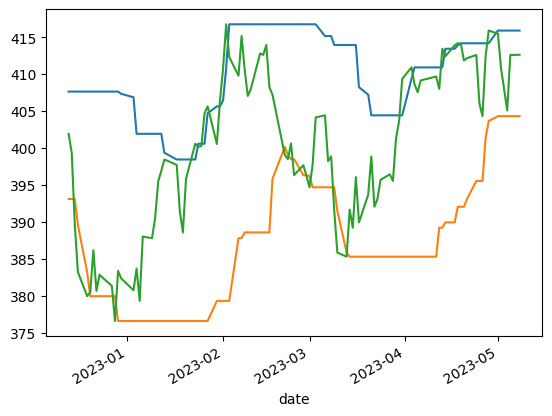

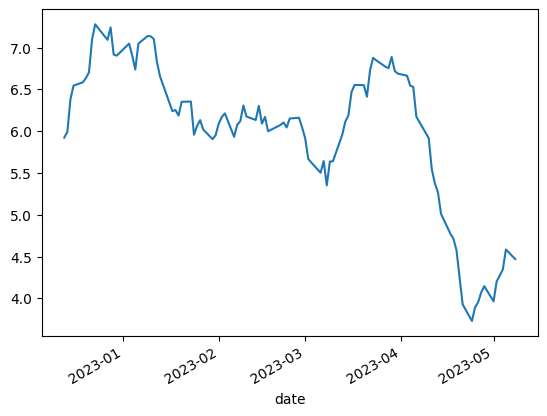

In [143]:
df['20_up_bound'] = df['close'].shift(1).rolling(20).max()
df['20_low_bound'] = df['close'].shift(1).rolling(20).min()
df['10_up_bound'] = df['close'].shift(1).rolling(10).max()
df['10_low_bound'] = df['close'].shift(1).rolling(10).min()


df = df.dropna()


df['High-Low'] = df['high'] - df['low']
df['High-PrevClose'] = abs(df['high'] - df['close'].shift(1))
df['Low-PrevClose'] = abs(df['low'] - df['close'].shift(1))
df['TR'] = df[['High-Low', 'High-PrevClose', 'Low-PrevClose']].max(axis=1)
df['ATR'] = df['TR'].rolling(20).mean()


df1 = df[-100:].copy()
df1['20_up_bound'].plot()
df1['20_low_bound'].plot()
df1['close'].plot()
plt.show()

df1['ATR'].plot()
plt.show()

In [144]:
bt = backTester()
df = df.dropna()
# df = df[-1000:]
bt.set_asset(df)
long_entry = df['20_up_bound'].to_numpy()
short_entry = df['20_low_bound'].to_numpy()
long_exit = df['10_low_bound'].to_numpy()
short_exit = df['10_up_bound'].to_numpy()
atr = df['ATR'].to_numpy()

long_trade = False

for i in range(len(bt.df)):
    order_quantity = 0
    order_price = 0
    risk_unit = int(bt.portfolio_value * 0.01 / (2 * atr[i]))
    open_trade = True
    if len(bt.open_trades) == 0:
        if bt.high[i] > long_entry[i]:
            print(f'high: {bt.high[i]} > long breakout: {long_entry[i]}')
            order_price = long_entry[i]
            order_quantity = risk_unit
            open_trade = True
            trail_dist = atr[i] * 2
            stop_loss = order_price - trail_dist
            long_trade = True

        # if bt.low[i] < short_entry[i]:
        #     order_price = short_entry[i]
        #     order_quantity = -risk_unit
        #     open_trade = True
        #     trail_dist = atr[i] * 2
        #     stop_loss = order_price + trail_dist
        #     long_trade = False
        
        
    else:
        print(f'stop_loss {stop_loss}, long_exit {long_exit[i]}')
        
        if long_trade:
            pass
            stop_loss = max(stop_loss, bt.high[i] - trail_dist)
            if bt.low[i] < stop_loss:
                print(f'low: {bt.low[i]} < stop_loss: {stop_loss}')
                print(f'exiting to stop_loss')
                for t in bt.open_trades:
                    order_quantity += -t.quantity
                order_price = stop_loss
                stop_loss = 0
                open_trade = False
            elif bt.low[i] < long_exit[i]:
                print(f'low: {bt.low[i]} < long exit: {long_exit[i]}')
                print(f'exiting to long_exit')
                for t in bt.open_trades:
                    order_quantity += -t.quantity
                order_price = long_exit[i]
                stop_loss = 0
                open_trade = False
        # else:
        #     stop_loss = min(stop_loss, bt.low[i] + trail_dist)
        #     if bt.high[i] > stop_loss:
        #         for t in bt.open_trades:
        #             order_quantity += -t.quantity
        #         order_price = stop_loss
        #         stop_loss = 0
        #         open_trade = False
        #     elif bt.high[i] > short_exit[i]:
        #         for t in bt.open_trades:
        #             order_quantity += -t.quantity
        #         order_price = short_exit[i]
        #         stop_loss = 0
        #         open_trade = False
            
            

    bt.take_action(order_quantity=order_quantity, order_price=order_price, open_trade=open_trade)

        


high: 45.03125 > long breakout: 44.625
opening trade (Timestamp('1993-05-19 00:00:00'), 44.625, 13008)
stop_loss 43.85625
stop_loss 44.3875
stop_loss 44.48125
stop_loss 44.48125
stop_loss 44.48125
stop_loss 44.85625
stop_loss 44.8875
stop_loss 44.8875
stop_loss 45.04375
stop_loss 45.04375
stop_loss 45.04375
stop_loss 45.04375
stop_loss 45.04375
low: 44.71875 < stop_loss: 45.04375
exiting to stop_loss
closing trade (Timestamp('1993-06-08 00:00:00'), 45.04375, 13008)
high: 45.21875 > long breakout: 45.0625
opening trade (Timestamp('1993-07-29 00:00:00'), 45.0625, 16584)
stop_loss 44.45625
stop_loss 44.4875
stop_loss 44.51875
stop_loss 44.58125
stop_loss 44.58125
stop_loss 44.58125
stop_loss 44.58125
stop_loss 44.7375
stop_loss 44.7375
stop_loss 44.7375
stop_loss 44.7375
stop_loss 44.7375
stop_loss 44.89375
stop_loss 44.925
stop_loss 45.26875
stop_loss 45.26875
stop_loss 45.26875
stop_loss 45.26875
stop_loss 45.6125
stop_loss 45.83125
stop_loss 45.925
stop_loss 45.925
stop_loss 45.925
sto

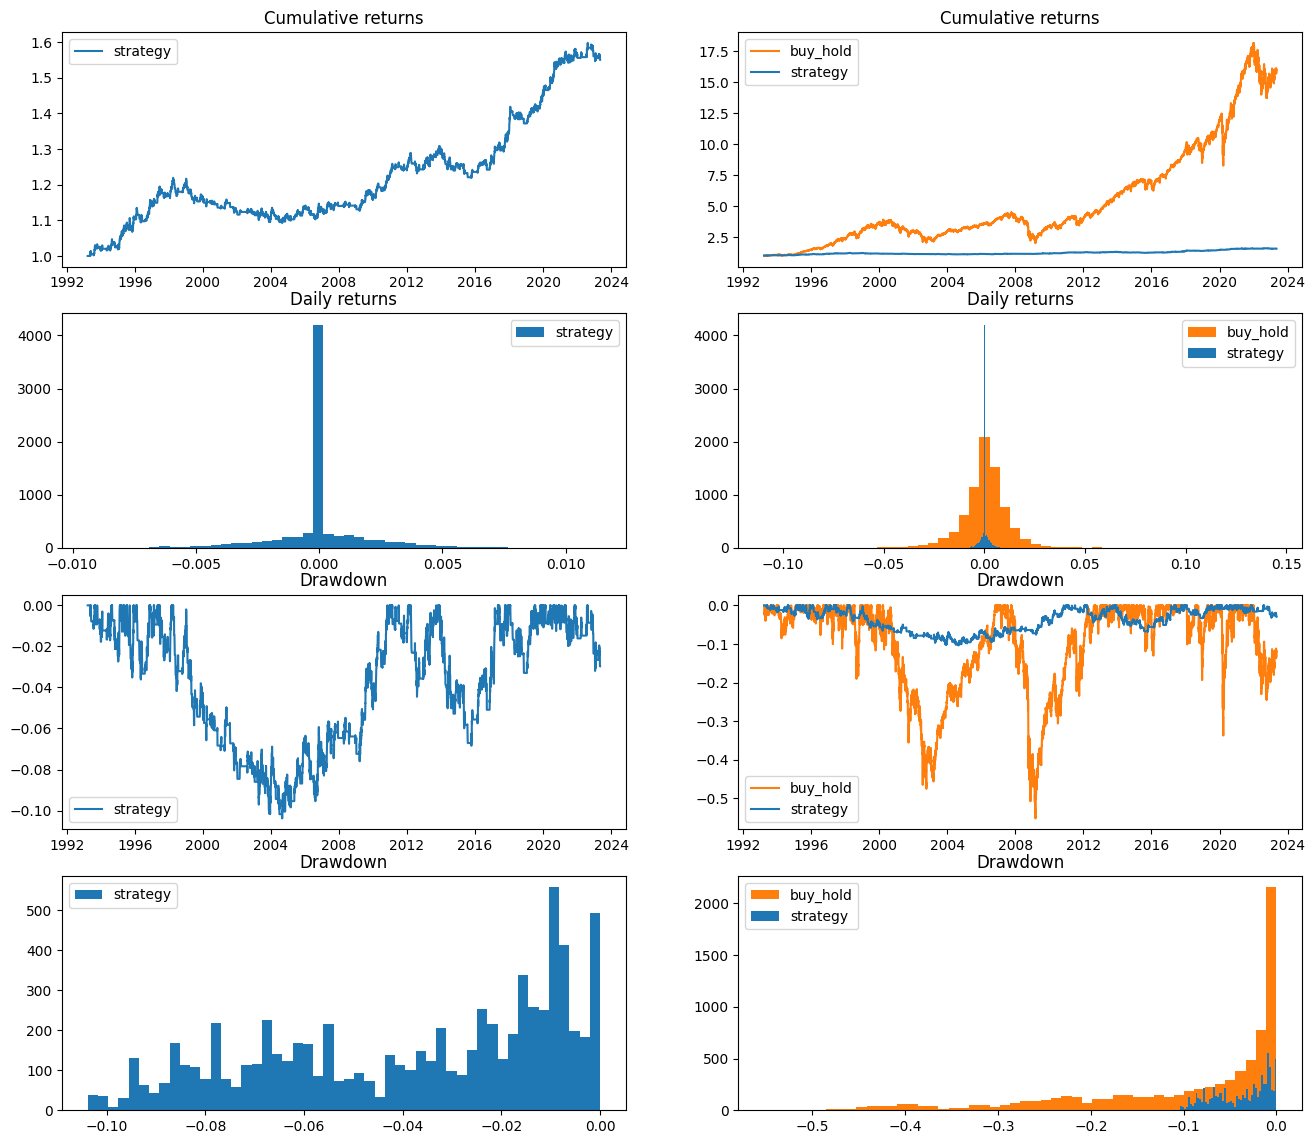

In [145]:
bt.analyse()
bt.plot_graphs()

In [146]:
print(f'Annualised return:          {bt.annual_return}')
print(f'buy_hold annual return:     {bt.buy_hold_annual_return}')
print(f'Annualised vol:             {bt.annual_vol}')
print(f'buy_hold annual vol:        {bt.buy_hold_annual_vol}')
print(f'Sharpe ratio:               {bt.sharpe}')
print(f'buy_hold Sharpe ratio:      {bt.buy_hold_sharpe}')

Annualised return:          0.014661104412201809
buy_hold annual return:     0.0964245000107764
Annualised vol:             0.030107069667370152
buy_hold annual vol:        0.18923549737496273
Sharpe ratio:               0.48696550591542354
buy_hold Sharpe ratio:      0.5095476342882701


In [147]:
bt.trade_record.analyse()
bt.trade_record.stats

{'num_wins': 142,
 'num_loss': 145,
 'win_rate': 0.49477351916376305,
 'profit_total': 550122.0126686095,
 'profit_mean': 1916.8014378697196,
 'returns_mean': 0.003945659179596074,
 'returns_std': 0.02624583397185015,
 'time_in_trade_mean': 17.181184668989548,
 'time_in_trade_std': 13.929464971629315,
 'capital_at_risk_mean': 565415.5179723016,
 'win_returns_mean': 0.0232356841377279,
 'win_returns_std': 0.023201086095385733,
 'win_profit_mean': 11015.712463470247,
 'win_time_in_trade_mean': 26.514084507042252,
 'win_time_in_trade_std': 13.874174138347,
 'loss_returns_mean': -0.01494526181388475,
 'loss_returns_std': 0.010712713879367036,
 'loss_profit_mean': -6993.856256166658,
 'loss_time_in_trade_mean': 8.041379310344828,
 'loss_time_in_trade_std': 5.183944045036459}

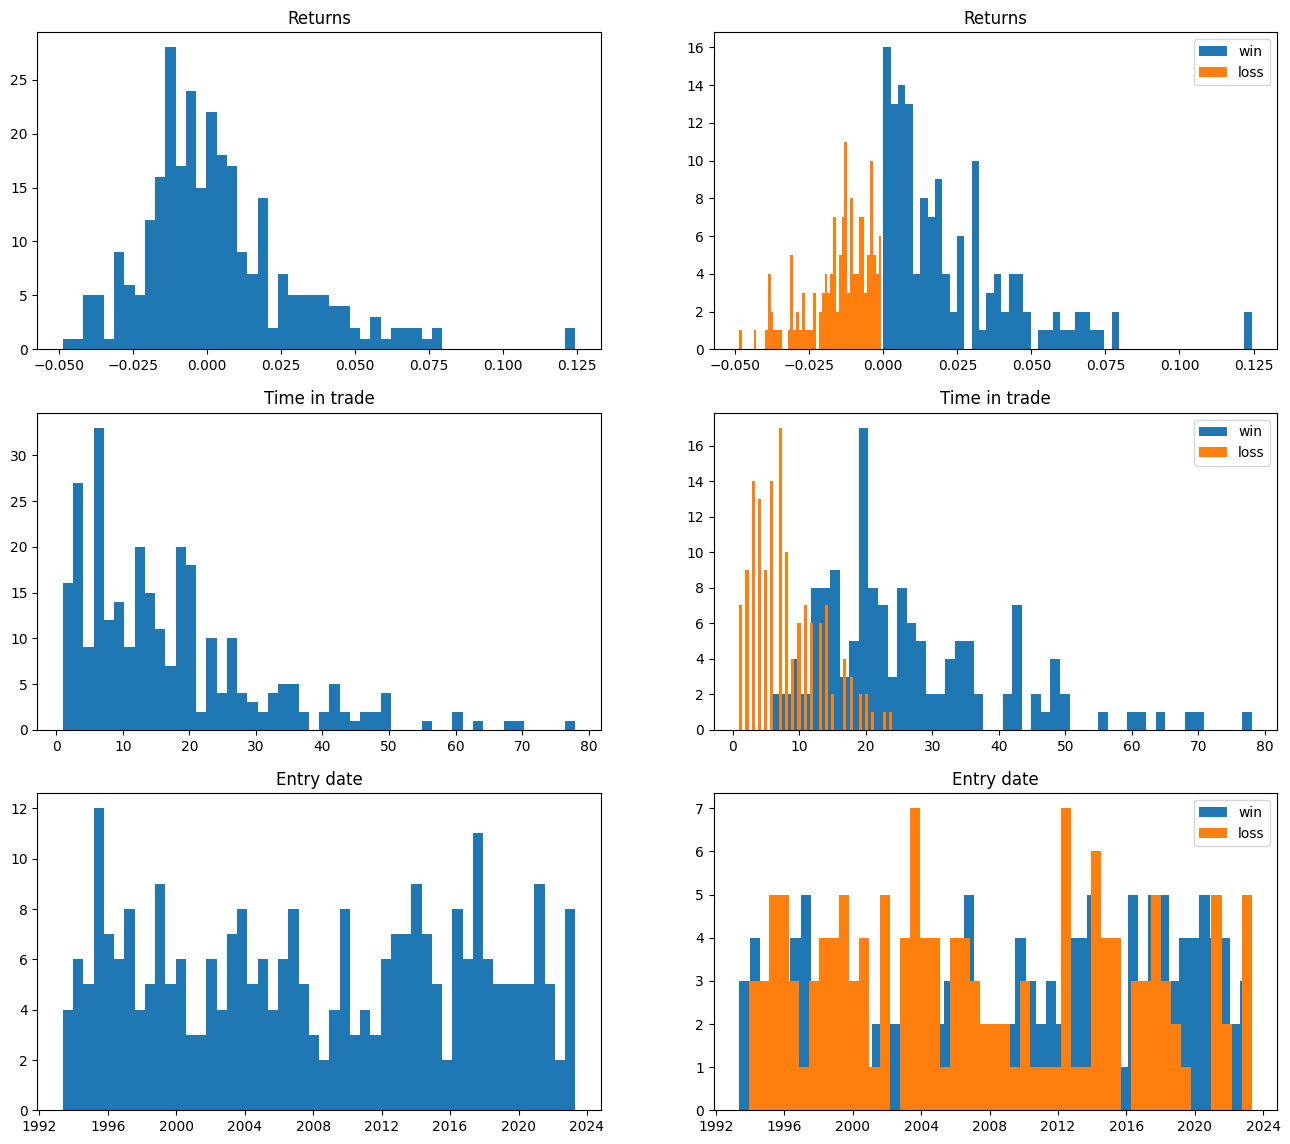

In [148]:
bt.trade_record.plot_graphs()

<Axes: >

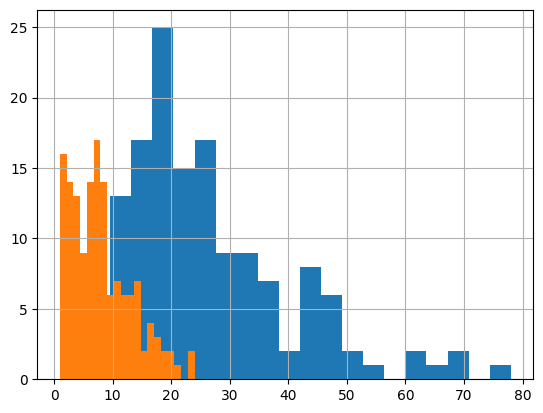

In [149]:
bt.trade_record.win_records['time_in_trade'].hist(bins=20)
bt.trade_record.loss_records['time_in_trade'].hist(bins=20)

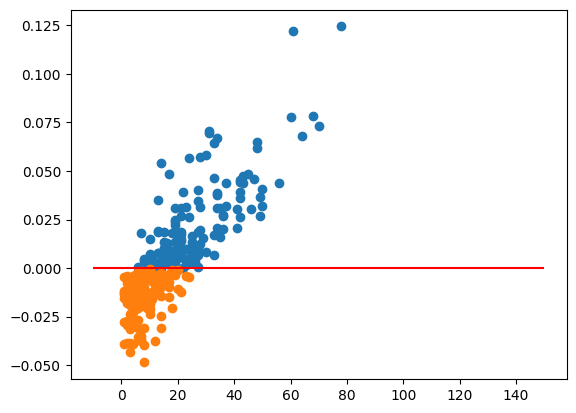

In [150]:
plt.scatter(bt.trade_record.win_records['time_in_trade'], bt.trade_record.win_records['returns'])
plt.scatter(bt.trade_record.loss_records['time_in_trade'], bt.trade_record.loss_records['returns'])
plt.hlines(0, -10, 150, color='red')